In [1]:
import geopandas
import pandas
import pathlib
import numpy
import matplotlib
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
sampling_resolution = 10
threshold = 1

## Load in results
### Widths and slopes

In [3]:
width_file = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\caches\100000000\final_transects_100000000.geojson")
rec_main_channel_file = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\caches\100000000\rec_main_channel.geojson")
widths = geopandas.read_file(width_file)
main_channel = geopandas.read_file(rec_main_channel_file)

### Slopes and Flows

In [4]:
mannings_file = pathlib.Path(r"C:\Users\pearsonra\Documents\data\river_bathemetry\mannings_n\bathy.csv.gz")
mannings = pandas.read_csv(mannings_file)

### Measured cross sections

In [5]:
cross_section_file = pathlib.Path(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Waikanae/Waikanae_Cross_Sections_NIWA/2014_Survey_XS_NZTM.shp")
cross_sections = geopandas.read_file(cross_section_file)

### Local datum conversion

In [75]:
local_datum_file = pathlib.Path(r"C:\Users\pearsonra\Documents\data\local_datums\lds-wellington-1953-to-nzvd2016-conversion-raster-GTiff.zip")

In [76]:
import rioxarray
with rioxarray.rioxarray.open_rasterio(base_path / r"waikanae\clipped\results\1m_100000000_gnd.nc", masked=True) as waikane_dem:
            waikane_dem.load()

# Translate the samples to correct reach

In [6]:
widths['nzsegment'] = numpy.zeros(len(widths['widths']), dtype=int) * -1
for i, row in main_channel.iterrows():
    widths.loc[widths.intersects(row.geometry), ('nzsegment')] = row['nzsegment']

# Add the flows and manning's n to the widths table

In [55]:
key_parameters = widths[['nzsegment', 'slope', 'widths_Savgol', 'geometry', 'min_z', 'min_z_unimodal', 'min_z_unimodal_0.5km_rolling_mean']]
key_parameters = key_parameters[key_parameters['nzsegment'] != 0]

In [56]:
key_parameters['mannings_n'] = numpy.zeros(len(key_parameters['nzsegment']), dtype=int)
key_parameters['flow'] = numpy.zeros(len(key_parameters['nzsegment']), dtype=int)
for nzsegment in key_parameters['nzsegment'].unique():
    key_parameters.loc[key_parameters['nzsegment'] == nzsegment, ('mannings_n')] = mannings[mannings['nzsegment'] == nzsegment]['n'].unique()[0]
    key_parameters.loc[key_parameters['nzsegment'] == nzsegment, ('flow')] = mannings[mannings['nzsegment'] == nzsegment]['flow'].unique()[0]

Note a section is out of order, which is why the flow goes down.

<AxesSubplot:>

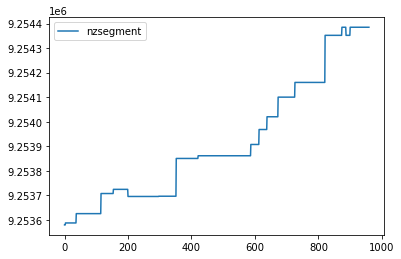

In [35]:
key_parameters[['nzsegment']].plot()

## Calculate depth

In [59]:
key_parameters['depth_Neal_et_al'] = (key_parameters['mannings_n'] * key_parameters['flow'] / (numpy.sqrt(key_parameters['slope']) * key_parameters['widths_Savgol'])) ** (3/5)

In [60]:
a = 0.745
b = 0.305
K_0 = 6.16

In [61]:
key_parameters['depth_Smart_et_al'] = (key_parameters['flow'] / (K_0 * key_parameters['widths_Savgol'] * key_parameters['slope'] ** b)) ** (1 / (1+a))

## Plot results
Include plots of each parameter - Manning's n, flow, depth and slope - used to calculate depth

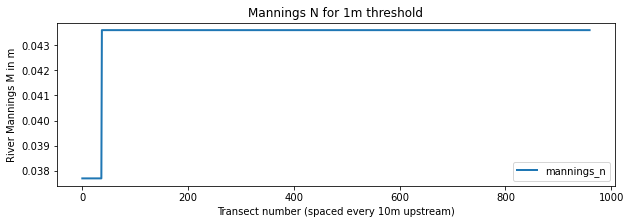

In [13]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['mannings_n']].plot(ax=ax, linewidth=2)
ax.set(title=f"Mannings N for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River Mannings M in m");

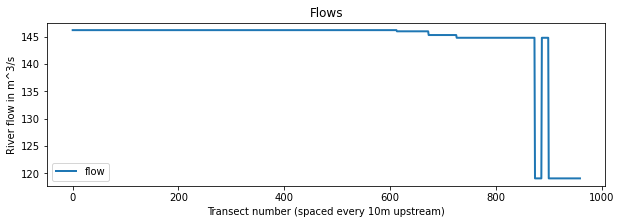

In [14]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['flow']].plot(ax=ax, linewidth=2)
ax.set(title=f"Flows")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River flow in m^3/s");

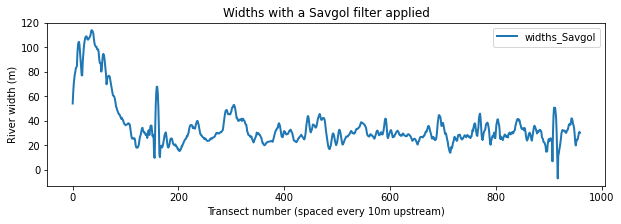

In [15]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['widths_Savgol']].plot(ax=ax, linewidth=2)
ax.set(title=f"Widths with a Savgol filter applied")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width (m)");

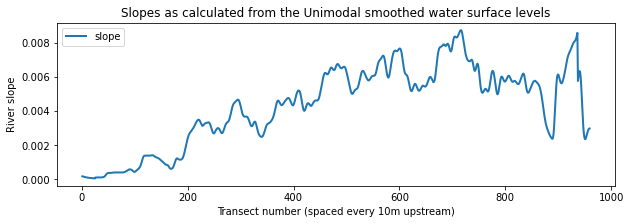

In [16]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['slope']].plot(ax=ax, linewidth=2)
ax.set(title=f"Slopes as calculated from the Unimodal smoothed water surface levels")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River slope");

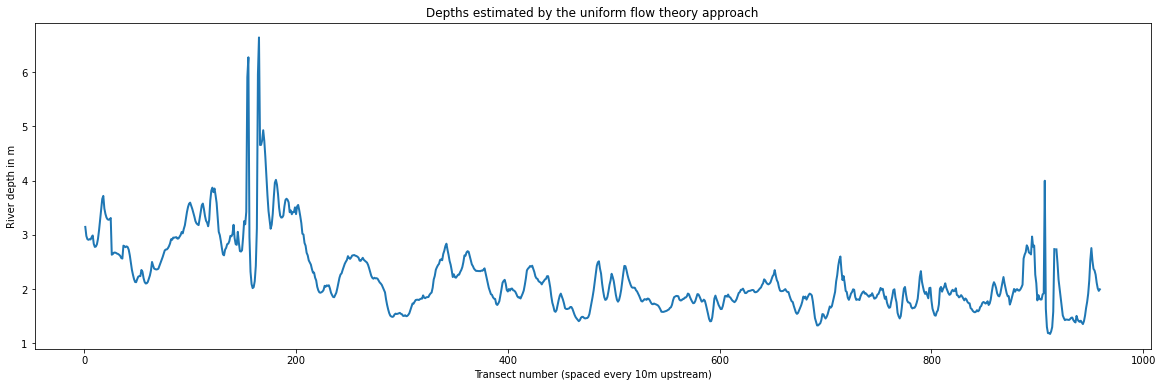

In [17]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
key_parameters['depth_Neal_et_al'].plot(ax=ax, linewidth=2)
ax.set(title=f"Depths estimated by the uniform flow theory approach")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");

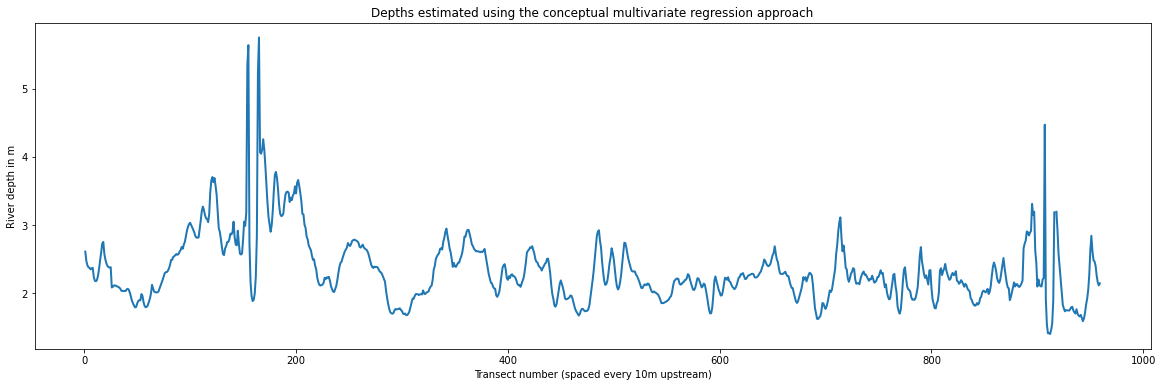

In [18]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
key_parameters['depth_Smart_et_al'].plot(ax=ax, linewidth=2)
ax.set(title="Depths estimated using the conceptual multivariate regression approach")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");

## Measured cross sections

Plot minimum height (i.e height of the bed)

<AxesSubplot:xlabel='Section'>

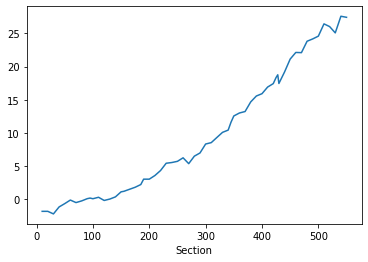

In [19]:
cross_sections.groupby('Section')['Level'].min().plot()

Pull out the centre point for each section - for idntification of the nearest sampled transect

In [20]:
section_centres = {'Section': [], 'geometry': []}
for section in cross_sections['Section'].unique():
    section_centre = cross_sections[cross_sections['Section'] == section].iloc[round(len(cross_sections[cross_sections['Section'] == section])/2)]
    section_centres['Section'].append(section_centre['Section'])
    section_centres['geometry'].append(section_centre['geometry'])
section_centres = geopandas.GeoDataFrame(section_centres)

Cycle through each section identifying the nearest section in the key parameters

In [63]:
nearest_transect = numpy.zeros_like(key_parameters['slope'], dtype=bool)
for index, row in section_centres.iterrows():
    nearest_transect[key_parameters.distance(row.geometry).argmin()] = True

nearest_key_parameters = key_parameters[nearest_transect]

Plot the results for different min_z values

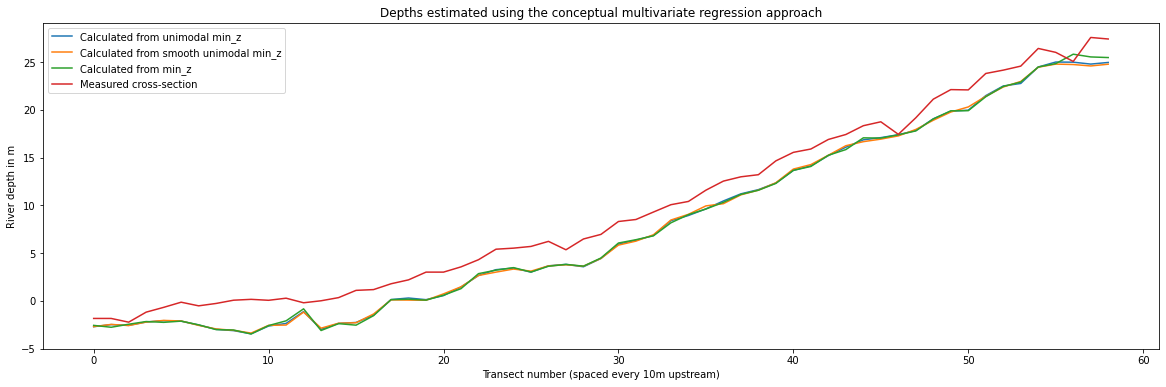

In [74]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters['min_z_unimodal']-nearest_key_parameters['depth_Smart_et_al']).reset_index(drop=True).plot(label='Calculated from unimodal min_z')
(nearest_key_parameters['min_z_unimodal_0.5km_rolling_mean']-nearest_key_parameters['depth_Smart_et_al']).reset_index(drop=True).plot(label='Calculated from smooth unimodal min_z')
(nearest_key_parameters['min_z']-nearest_key_parameters['depth_Smart_et_al']).reset_index(drop=True).plot(label='Calculated from min_z')
cross_sections.groupby('Section')['Level'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title="Depths estimated using the conceptual multivariate regression approach")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()

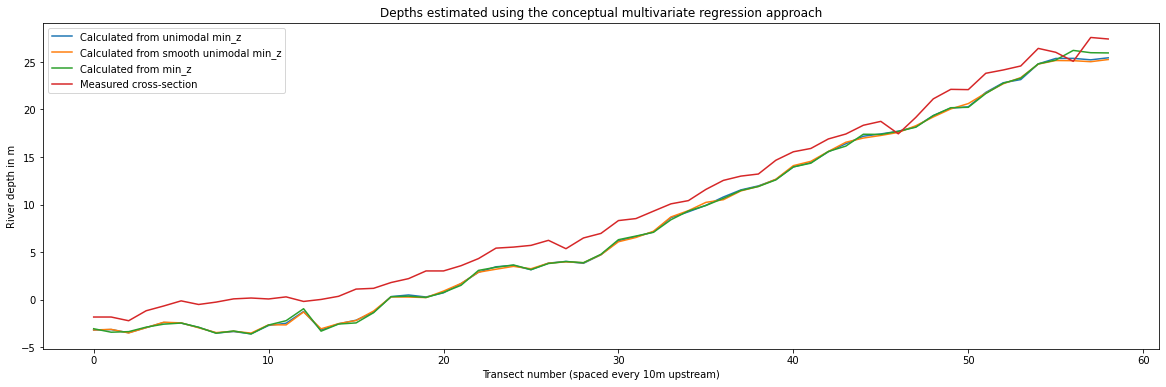

In [73]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters['min_z_unimodal']-nearest_key_parameters['depth_Neal_et_al']).reset_index(drop=True).plot(label='Calculated from unimodal min_z')
(nearest_key_parameters['min_z_unimodal_0.5km_rolling_mean']-nearest_key_parameters['depth_Neal_et_al']).reset_index(drop=True).plot(label='Calculated from smooth unimodal min_z')
(nearest_key_parameters['min_z']-nearest_key_parameters['depth_Neal_et_al']).reset_index(drop=True).plot(label='Calculated from min_z')
cross_sections.groupby('Section')['Level'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title="Depths estimated using the conceptual multivariate regression approach")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()

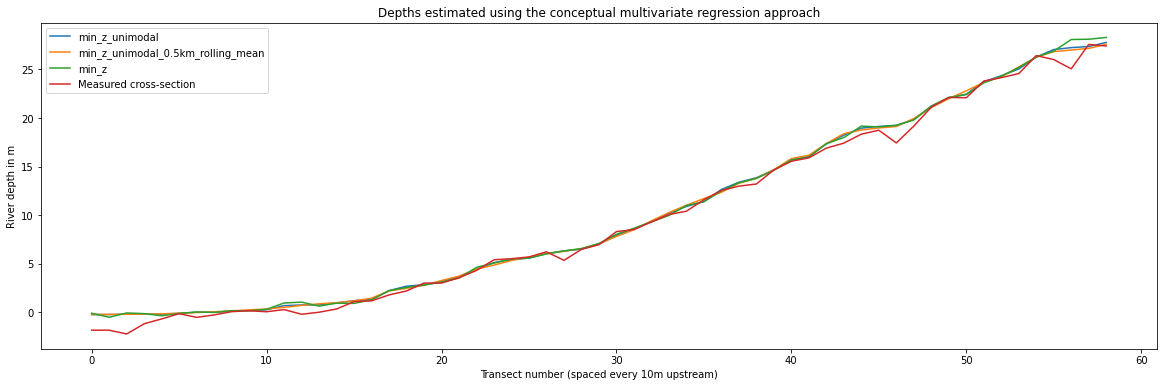

In [72]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
nearest_key_parameters[['min_z_unimodal', 'min_z_unimodal_0.5km_rolling_mean', 'min_z']].reset_index(drop=True).plot(ax=ax)
cross_sections.groupby('Section')['Level'].min().reset_index(drop=True).plot(ax=ax, label='Measured cross-section')
ax.set(title="Depths estimated using the conceptual multivariate regression approach")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()

In [68]:
len(nearest_key_parameters)

59

In [69]:
len(cross_sections)

4216

In [71]:
cross_sections.groupby('Section')['Level'].min().reset_index(drop=True)

0     -1.84
1     -1.84
2     -2.23
3     -1.18
4     -0.68
5     -0.14
6     -0.52
7     -0.27
8      0.07
9      0.16
10     0.06
11     0.28
12    -0.20
13     0.01
14     0.34
15     1.10
16     1.18
17     1.79
18     2.20
19     3.01
20     3.01
21     3.56
22     4.31
23     5.41
24     5.52
25     5.70
26     6.23
27     5.35
28     6.48
29     6.96
30     8.31
31     8.52
32     9.30
33    10.07
34    10.41
35    11.59
36    12.54
37    12.99
38    13.21
39    14.66
40    15.55
41    15.90
42    16.90
43    17.42
44    18.34
45    18.75
46    17.44
47    19.17
48    21.12
49    22.12
50    22.09
51    23.81
52    24.16
53    24.58
54    26.43
55    26.02
56    25.07
57    27.58
58    27.42
Name: Level, dtype: float64